In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')     # Стиль графиков, можно закомментировать
plt.rcParams['figure.figsize'] = (10, 7.5)              

import sklearn
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix

Ссылка на датасет: https://www.openml.org/d/40975

**Attribute Information**:

Class Values: *unacc*, *acc*, *good*, *vgood*

**Attributes**:

buying: *vhigh*, *high*, *med*, *low*.

maint: *vhigh*, *high*, *med*, *low*.

doors: 2, 3, 4, 5, more.

persons: 2, 4, more.

lug_boot: *small*, *med*, *big*.

safety: *low*, *med*, *high*.

С помощью встроенного метода в sklearn можно загрузить данные прямо в google.colab в переменную с именем data

In [ ]:
data = datasets.fetch_openml(name='car', version="3")       # Загрузка датасета с OpenML

In [ ]:
# Предикторы X
Predictors = data.get('data')
Predictors.head()

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med


In [ ]:
# Отклики Y
Target = data.get('target')
Target.head()

0    unacc
1    unacc
2    unacc
3    unacc
4    unacc
Name: class, dtype: category
Categories (4, object): ['unacc', 'acc', 'good', 'vgood']

In [ ]:
# Количество строк в данных
print("Размер таблицы данных X", Predictors.shape)
print("Размер вектора откликов Y", Target.shape)

Размер таблицы данных X (1728, 6)
Размер вектора откликов Y (1728,)


Исследование данных на пропуски

In [ ]:
Predictors.isna().sum()     # Использование методов объектов pd.DataFrame и np.ndarray

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
dtype: int64

In [ ]:
Target.isna().sum()

0

Типы данных столбцов

In [ ]:
Predictors.describe()       # Типы данных всех столбцов -- категориальные

,buying,maint,doors,persons,lug_boot,safety
count,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3
top,vhigh,vhigh,2,2,small,low
freq,432,432,432,576,576,576


In [ ]:
unique_targets = list(set(Target))
Target_dict = dict(zip(unique_targets, range(len(unique_targets))))
Target = Target.replace(to_replace=unique_targets, value=list(Target_dict.values()))

In [ ]:
Target

0       3
1       3
2       3
3       3
4       3
       ..
1723    0
1724    1
1725    3
1726    0
1727    1
Name: class, Length: 1728, dtype: int64

Создание дамми-переменных

In [ ]:
Predictors_dummies = pd.get_dummies(Predictors, prefix=Predictors.columns)
Predictors_dummies = Predictors_dummies[Predictors_dummies.columns].astype('category')
print(Predictors_dummies.describe())
Predictors_dummies = Predictors_dummies[Predictors_dummies.columns].astype('float')

        buying_vhigh  buying_high  buying_med  buying_low  maint_vhigh  \
count           1728         1728        1728        1728         1728   
unique             2            2           2           2            2   
top                0            0           0           0            0   
freq            1296         1296        1296        1296         1296   

        maint_high  maint_med  maint_low  doors_2  doors_3  ...  doors_5more  \
count         1728       1728       1728     1728     1728  ...         1728   
unique           2          2          2        2        2  ...            2   
top              0          0          0        0        0  ...            0   
freq          1296       1296       1296     1296     1296  ...         1296   

        persons_2  persons_4  persons_more  lug_boot_small  lug_boot_med  \
count        1728       1728          1728            1728          1728   
unique          2          2             2               2             2   


Разделение выборок на тренировочную и тестовую

In [ ]:
test_ratio = 0.2

X_train, X_test, Y_train, Y_test = train_test_split(Predictors_dummies, 
                                                    Target, 
                                                    test_size = test_ratio, 
                                                    random_state=123)

print(X_train.shape)
print(X_test.shape)

(1382, 21)
(346, 21)


Графическое предобследование данных

{'good': 0, 'vgood': 1, 'acc': 2, 'unacc': 3}


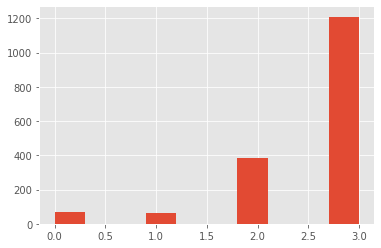

In [ ]:
plt.hist(Target)
print(Target_dict)

Данные не являются сбалансированными

# **Классификация**


## Бинарная классификация

Функция оценки вероятности -- сигмоида $f(x)$
\begin{equation}
f(x) = \cfrac{1}{1 + e^{-x}}
\end{equation}

\begin{equation}
f(Y=0 | x) = \cfrac{e^{-x}}{1 + e^{-x}}, \ f(Y=1 | x) = \cfrac{1}{1 + e^{-x}}
\end{equation}

Производная функции оценки вероятности в зависимости от сигмоиды

\begin{equation}
f^{'}(x) = \cfrac{0 \cdot (1 + e^{-x}) - 1 \cdot (- e^{-x}) }{(1 + e^{-x})^2} = \cfrac{e^{-x}}{(1 + e^{-x})^2} = \cfrac{1 - 1 + e^{-x}}{(1 + e^{-x})^2}
\end{equation}

\begin{equation}
f^{'}(x) = \cfrac{1 + e^{-x}}{(1 + e^{-x})^2} - \cfrac{1}{(1 + e^{-x})^2} = f(x) - f(x)^2
\end{equation}


\\

\begin{equation}
f^{'}(x) = f(x) \cdot (1 - f(x))
\end{equation}

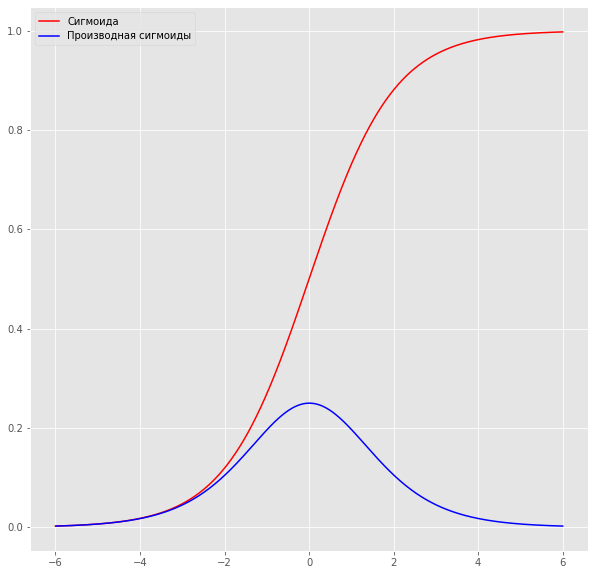

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

X = np.linspace(-6, 6, 1000)

plt.figure(figsize = (10, 10))
plt.plot(X, sigmoid(X), c='r', label="Сигмоида")
plt.plot(X[1:], np.diff(sigmoid(X)) / np.diff(X), 
         c='b', label="Производная сигмоиды")
plt.legend()

Если пропустить линейную модель:

\begin{equation}
\hat{Y}(x, \omega) = \sum_{i = 0}^{n} \omega_i \cdot x_i
\end{equation}

Через функцию активации $f(x)$, то а выходе мы получим сконвертированную в вероятности оценку наблюдать класс.

\begin{equation}
P(Y|X) = f(\hat{Y}(X, \omega))
\end{equation}

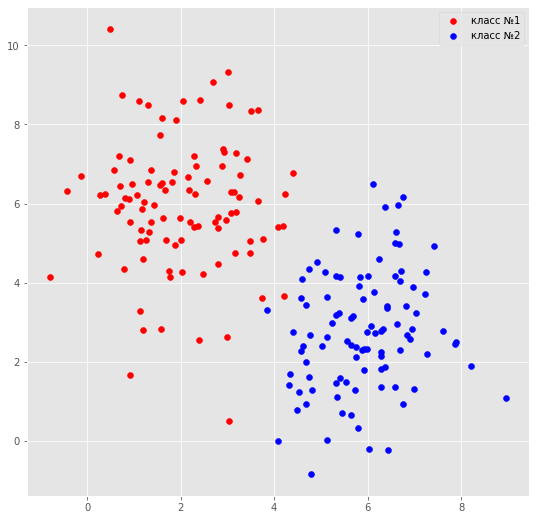

In [ ]:
np.random.seed(123)
points = 100
x1, y1 = np.random.normal(2, 1, size = points), np.random.normal(6, 1.7, size = points)
x2, y2 = np.random.normal(6, 1, size = points), np.random.normal(3, 1.7, size = points)

plt.figure(figsize = (9, 9))
plt.scatter(x1, y1, c = 'r', label = "класс №1")
plt.scatter(x2, y2, c = 'b', label = "класс №2")
plt.legend()

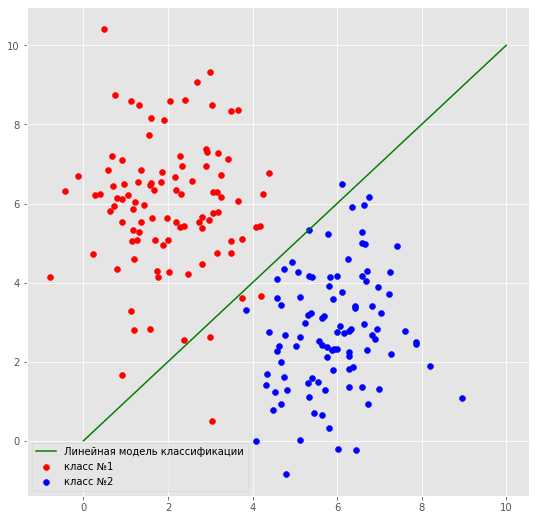

In [ ]:
def model(x, omega0, omega1):
    return omega0 + omega1 * x

def classif_model(x, omega0, omega1, model):
    return sigmoid(model(x, omega0, omega1))

omega0 = 0
omega1 = 1
X = np.linspace(0, 10, 1000)

plt.figure(figsize = (9, 9))
plt.scatter(x1, y1, c = 'r', label = "класс №1")
plt.scatter(x2, y2, c = 'b', label = "класс №2")
plt.plot(X, model(X, omega0, omega1), c = "g", 
         label = "Линейная модель классификации")
plt.legend()

Loss -- функция, или функция потерь, по которой, минимизируя, мы должны будем обучать наши веса, в случае бинарной классификации называется **Бинарной перекрёстной энтропией** (binary cross-entropy)

\begin{equation}
BCE(x, \omega) = - Y \cdot ln(f(\hat{Y}(x, \omega))) - (1 - Y) \cdot ln(1 - f(\hat{Y}(x, \omega)))
\end{equation}

\\

\begin{equation}
\cfrac{\partial BCE(x, \omega)}{\partial \omega} = - Y \cdot \cfrac{1}{f(\hat{Y}(x, \omega))} \cdot f(\hat{Y}(x, \omega)) \cdot (1 - f(\hat{Y}(x, \omega)) \cdot \cfrac{\partial \hat{Y}(x, \omega)}{\partial \omega} + (1 - Y) \cdot \cfrac{1}{1 - f(\hat{Y}(x, \omega))} \cdot f(\hat{Y}(x, \omega)) \cdot (1 - f(\hat{Y}(x, \omega))) \cdot \cfrac{\partial \hat{Y}(x, \omega)}{\partial \omega}
\end{equation}

\begin{equation}
\cfrac{\partial BCE(x, \omega)}{\partial \omega} = - Y \cdot (1 - f(\hat{Y}(x, \omega)) \cdot \cfrac{\partial \hat{Y}(x, \omega)}{\partial \omega} + (1 - Y) \cdot f(\hat{Y}(x, \omega)) \cdot \cfrac{\partial \hat{Y}(x, \omega)}{\partial \omega}
\end{equation}

\begin{equation}
\cfrac{\partial BCE(x, \omega)}{\partial \omega} = (- Y + f(\hat{Y}(x, \omega)) \cdot \cfrac{\partial \hat{Y}(x, \omega)}{\partial \omega}
\end{equation}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Визуализация loss-функции BCE')

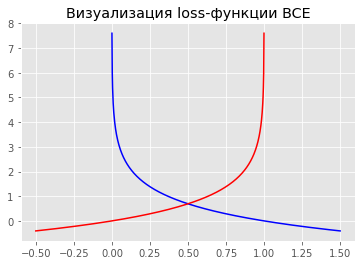

In [ ]:
X = np.linspace(-0.5, 1.5, 1000)
plt.plot(X, -np.log(X), c = "b", label = "Шанс Y = 1")
plt.plot(X, -np.log(1 - X), c = "r", label = "Шанс Y = 0")
plt.title("Визуализация loss-функции BCE")

## Многоклассовая классификация

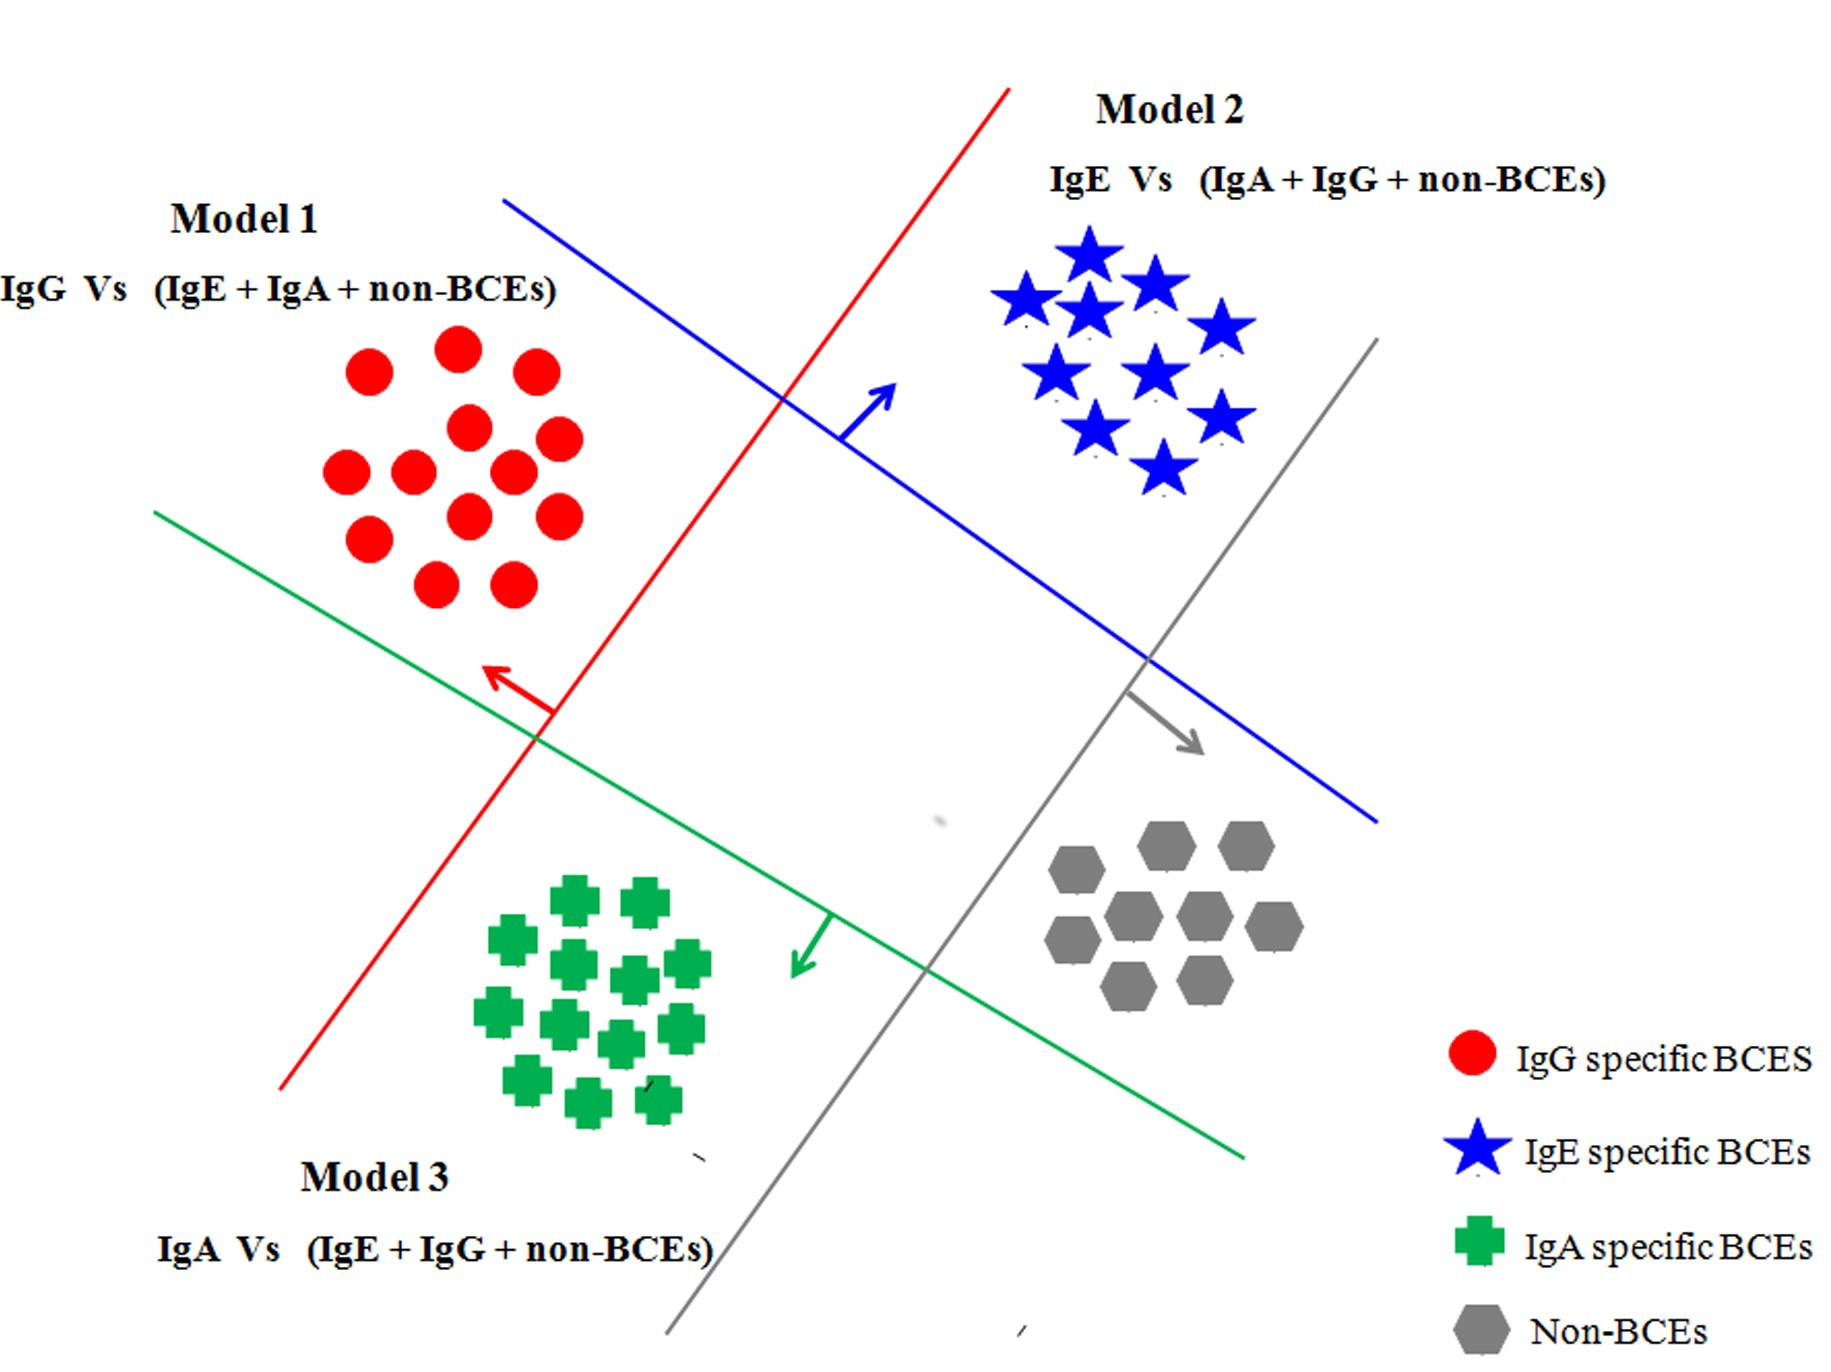

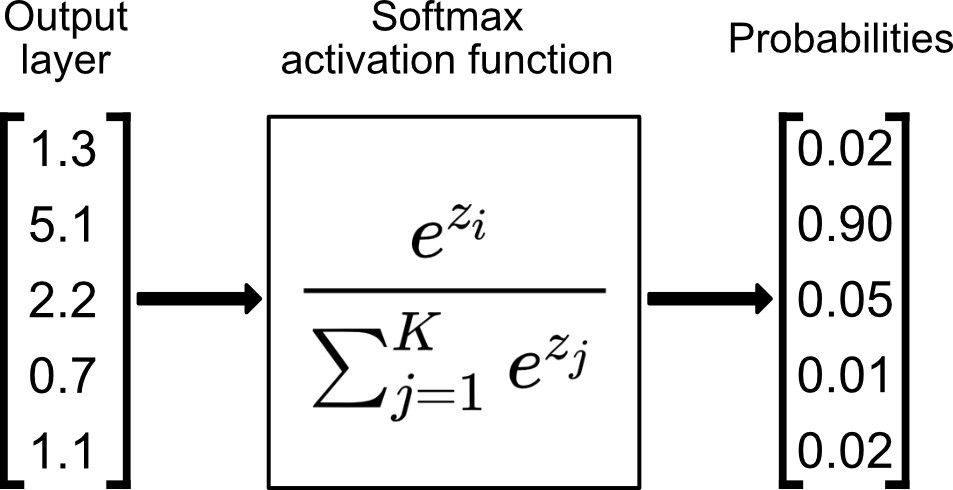

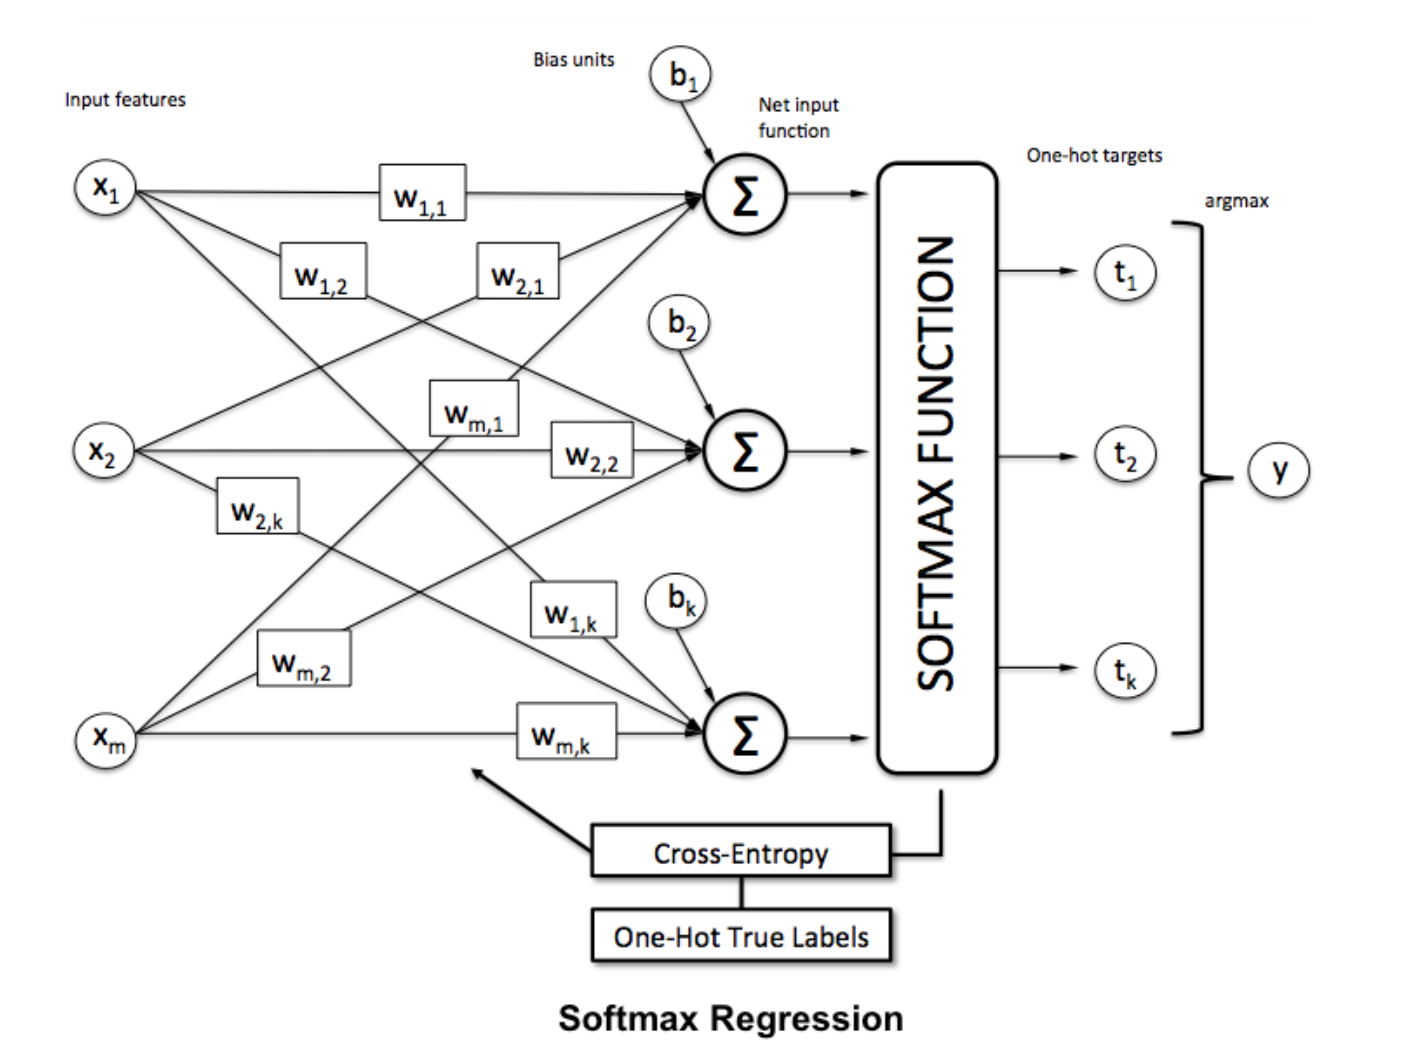

\begin{equation}
SM(z_i) = \cfrac{e^{z_i}}{\sum_{k = 1}^{K} e^{z_k}}
\end{equation}

\\

\begin{equation}
CE(\omega, z) = \sum_{k = 1}^{K} -t_k \cdot log(SM(z_k, \omega))
\end{equation}

## Метрики классификации

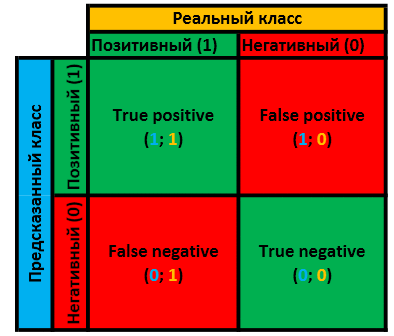


**TP** — количество True Positive результатов на данной выборке.

**TN** — количество True Negative результатов на данной выборке.

**FP** — количество False Positive результатов на данной выборке.

**FN** — количество False Negative результатов на данной выборке.

Метрика точности показывает показывает, сколько из предсказанных позитивных объектов, оказались действительно позитивными.

\begin{equation}
Precision = \cfrac{TP}{TP + FP}
\end{equation}

Метрика полнота показывает показывает, сколько от общего числа реальных позитивных объектов, было предсказано, как позитивный класс.

\begin{equation}
Recall = \cfrac{TP}{TP + FN}
\end{equation}

**F**-мера -- характеристика, которая позволяет дать оценку одновременно по точности и полноте. 

**$F_1$**-мера задана при $\alpha = 0.5$ 

\begin{equation}
F_1 = \cfrac{1}{\alpha \cdot \frac{1}{Precision} + (1 - \alpha) \cdot \frac{1}{Recall}} = \cfrac{2 \cdot Precision \cdot Recall}{Precision + Recall}
\end{equation}

## Поиск по сетке

Поиск по сетке -- метод настройки гиперпараметров модели, при котором задается сетка поиска гиперпараметров (search space), и затем обучение модели проводится по кросс-валидации с оценкой качества на валидационной выборке. Лучший вектор гиперпараметров определяется исходя из минимума ошибки на кросс-валидационной проверке.

Тем самым -- обучение **параметров** минимизирует функцию потерь на тренировочной выборке, обучение **гиперпараметров** минимизирует функцию потерь на валидационной выборке. Качество обученной модели *в бою* проверяется на тестовой отложенной выборке.



# **Логистическая регрессия**

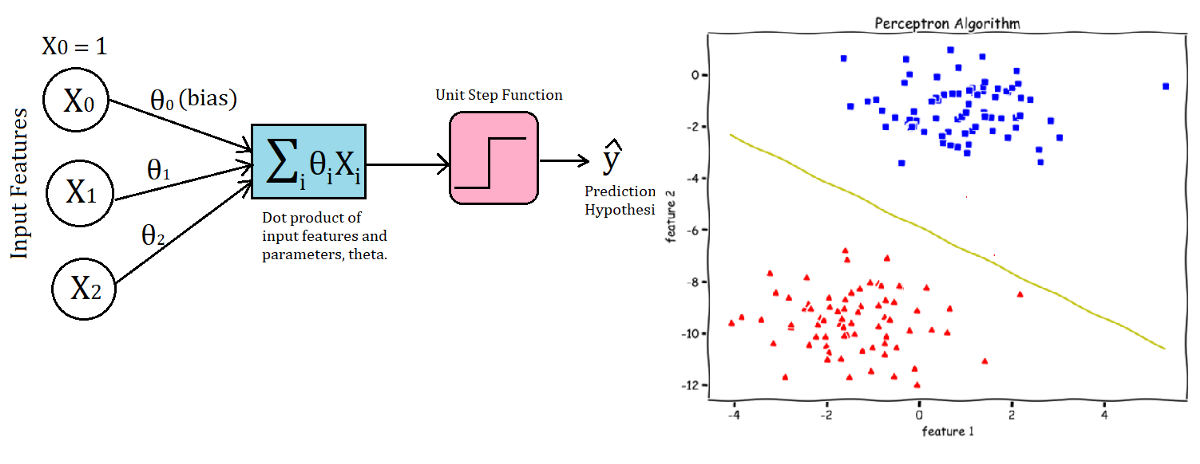

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [ ]:
model_logistic = LogisticRegressionCV(Cs = np.linspace(0, 20, 200), cv = 4)
model_logistic.fit(X_train, Y_train)
model_logistic.score(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:811: RuntimeWarning: divide by zero encountered in double_scalars
  args=(X, target, 1.0 / C, sample_weight),
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:301: RuntimeWarning: invalid value encountered in double_scalars
  loss += 0.5 * alpha * squared_norm(w)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:352: RuntimeWarning: invalid value encountered in multiply
  grad[:, :n_features] += alpha * w
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_war

0.9450072358900145

In [ ]:
preds = model_logistic.predict(X_test)
confusion_matrix(Y_test, preds)

array([[ 11,   2,   0,   0],
       [  0,  11,   1,   0],
       [  2,   1,  77,   4],
       [  0,   0,  14, 223]])

In [ ]:
print(classification_report(Y_test, preds, target_names = unique_targets))

              precision    recall  f1-score   support

        good       0.85      0.85      0.85        13
       vgood       0.79      0.92      0.85        12
         acc       0.84      0.92      0.88        84
       unacc       0.98      0.94      0.96       237

    accuracy                           0.93       346
   macro avg       0.86      0.91      0.88       346
weighted avg       0.94      0.93      0.93       346



# **KNN** (Метод ближайших соседей)

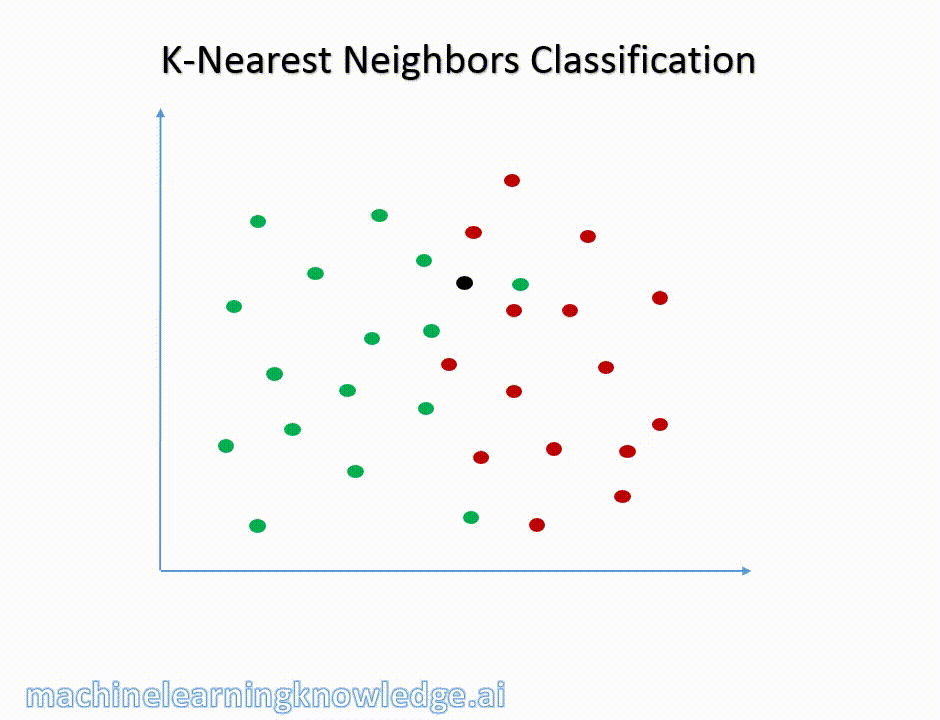

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
number_of_neighbors = np.arange(3, 25, 2)
model_KNN = KNeighborsClassifier()
params = {"n_neighbors": number_of_neighbors}

grid_search = GridSearchCV(estimator = model_KNN, 
                           param_grid = params, cv = 6)

In [ ]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=6, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])})

In [ ]:
grid_search.best_score_

0.9261873392308174

In [ ]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=9)

In [ ]:
preds_knn = grid_search.predict(X_test)

In [ ]:
confusion_matrix(Y_test, preds_knn)

array([[  7,   1,   5,   0],
       [  1,  11,   0,   0],
       [  1,   1,  76,   6],
       [  0,   0,   2, 235]])

In [ ]:
print(classification_report(Y_test, preds_knn))

              precision    recall  f1-score   support

           0       0.78      0.54      0.64        13
           1       0.85      0.92      0.88        12
           2       0.92      0.90      0.91        84
           3       0.98      0.99      0.98       237

    accuracy                           0.95       346
   macro avg       0.88      0.84      0.85       346
weighted avg       0.95      0.95      0.95       346



# **SVM** (Машина опорных векторов)

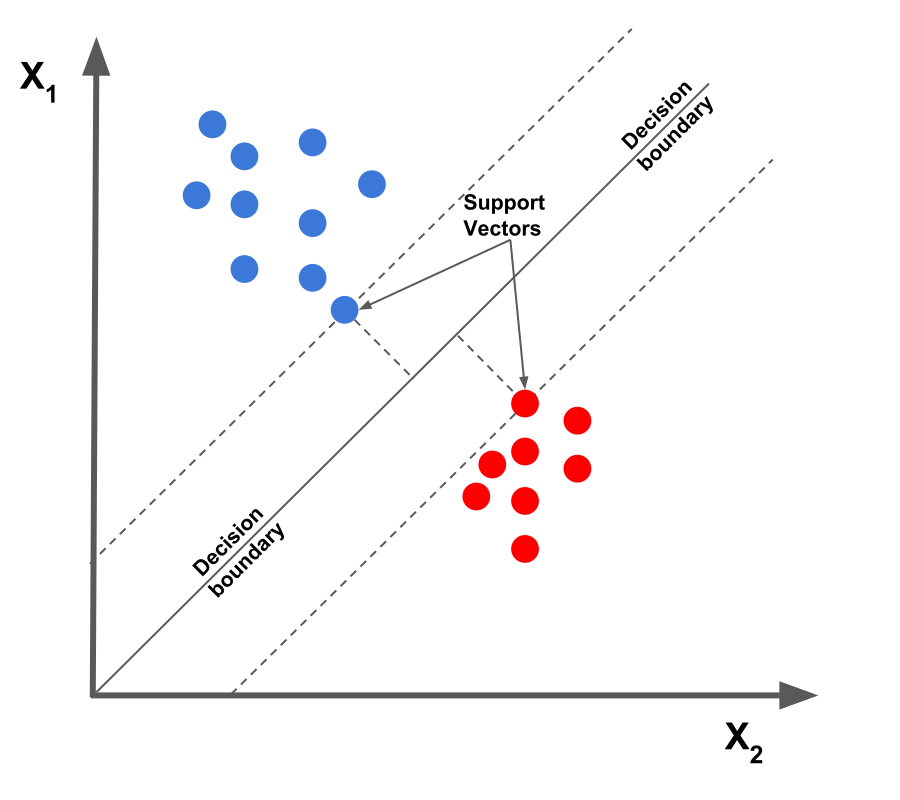

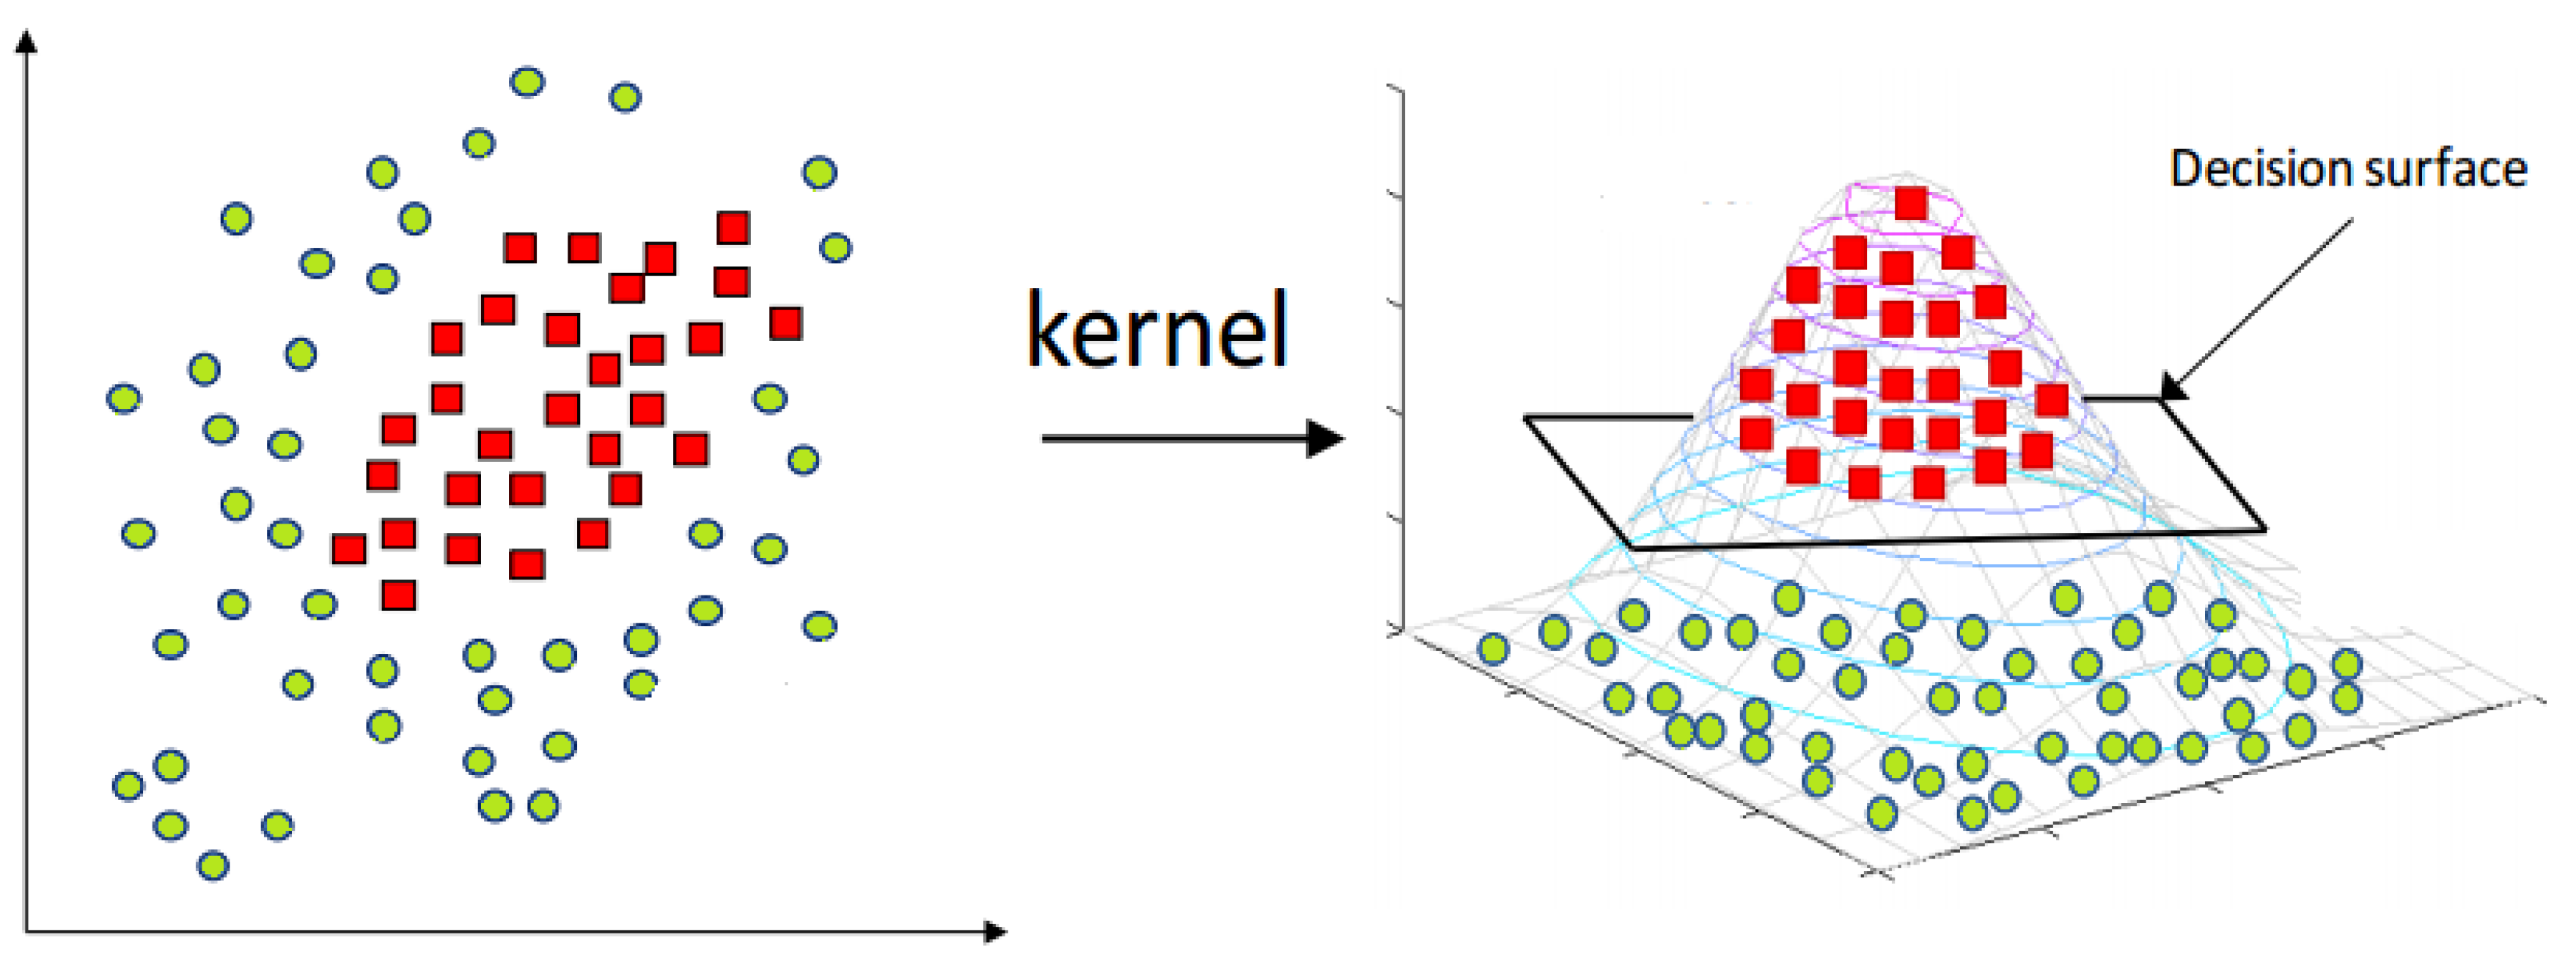

In [ ]:
from sklearn.svm import SVC
line_param = np.linspace(1, 20, 100)
parameters = {'kernel':('linear', 'rbf', "poly", "sigmoid"), 'C':line_param}
SVC()
model = SVC()
grid_search_svm = GridSearchCV(estimator=model, param_grid=parameters, cv = 6)
grid_search_svm.fit(X_train, Y_train)
grid_search_svm.best_score_

0.994940084070519

In [ ]:
grid_search_svm.best_estimator_

SVC(C=1.9595959595959596, kernel='poly')

In [ ]:
preds_svm = grid_search_svm.predict(X_test)
print(classification_report(Y_test, preds_svm, target_names = unique_targets))

              precision    recall  f1-score   support

        good       0.93      1.00      0.96        13
       vgood       1.00      1.00      1.00        12
         acc       1.00      0.99      0.99        84
       unacc       1.00      1.00      1.00       237

    accuracy                           1.00       346
   macro avg       0.98      1.00      0.99       346
weighted avg       1.00      1.00      1.00       346



In [ ]:
confusion_matrix(Y_test, preds_svm)

array([[ 13,   0,   0,   0],
       [  0,  12,   0,   0],
       [  1,   0,  83,   0],
       [  0,   0,   0, 237]])